<a href="https://colab.research.google.com/github/skc46/Machine_learning_notebooks/blob/master/Higgs_vs_background.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Higgs vs background signal classification

**Background:** High-energy collisions at the Large Hadron Collider (LHC) produce particles that interact with particle detectors. One important task is to classify different types of collisions based on their physics content, allowing physicists to find patterns in the data and to potentially unravel new discoveries. 

**Problem statement:** The discovery of the Higgs boson by CMS and ATLAS Collaborations was announced at CERN in 2012. In this work, we focus on the potential of Machine Learning and Deep Learning in detecting potential Higgs signal from one of the background processes that mimics it. 

**Dataset:** The dataset is made available by the Center for Machine Learning and Intelligent Systems at University of California, Irvine. 
The dataset can be found on the [UCI Machine learning Repository](https://archive.ics.uci.edu/ml/datasets/HIGGS)

**Description:** The dataset consists of a total of 11 million labeled samples of Higgs vs background events produced by Monte Carlo simulations. Each sample consists of 28 features. The first 21 features are kinematic properties measured at the level of the detectors. The last seven are functions of the first 21.




**Steps to load the training dataset**
1. Download the dataset from the UCI website. 

In [ ]:
pip install wget

In [3]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz

--2021-05-13 23:20:39--  https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2816407858 (2.6G) [application/x-httpd-php]
Saving to: ‘HIGGS.csv.gz’

HIGGS.csv.gz        100%[===================>]   2.62G  56.1MB/s    in 49s     

2021-05-13 23:21:29 (54.8 MB/s) - ‘HIGGS.csv.gz’ saved [2816407858/2816407858]



2. Unzip the dataset folder

In [4]:
!gzip -d HIGGS.csv.gz

In [ ]:
pip install plot-metric ## For plotting ROC at the end

Note: you may need to restart the kernel to use updated packages.


In [5]:
from sklearn.datasets import make_gaussian_quantiles
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from xgboost import XGBClassifier

In [6]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [7]:
import numpy as np
np.random.seed(1337)  # for reproducibility
import h5py
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import roc_curve, auc,roc_auc_score

import matplotlib.pyplot as plt

**Load the file using pandas library**

In [8]:
data=pd.read_csv('./HIGGS.csv')

Assign first column 0 to class labels (labeled 1 for signal, 0 for background)  and all others to feature matrix X.

In this example, for the sake of fast checking, we use 1000 samples. To train on the entire dataset, proceed with uncommenting the lines below. 

In [9]:
data.shape

(10999999, 29)

In [11]:
X=data.iloc[:,1:]
#X = data.iloc[:,1:]
y=data.iloc[:,0]
#y = data.iloc[:,0]


Split your data into training and validation samples where the fraction of the data used for validation is 33%. 

In [12]:
X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train1, y_train1, test_size=0.2, random_state=42)

In [13]:
print("X_train shape",X_train.shape)
print("X_val shape",X_val.shape)
print("X_test shape", X_test.shape)

X_train shape (7039999, 28)
X_val shape (2200000, 28)
X_test shape (1760000, 28)


**Visualize your data - One histogram per feature column**

Detailed information on what each feature column is can be found in *Attribute Information* section on the [UCI Machine learning Repositery](https://archive.ics.uci.edu/ml/datasets/HIGGS). For further information, refer to the [paper](https://www.nature.com/articles/ncomms5308) by Baldi et. al 

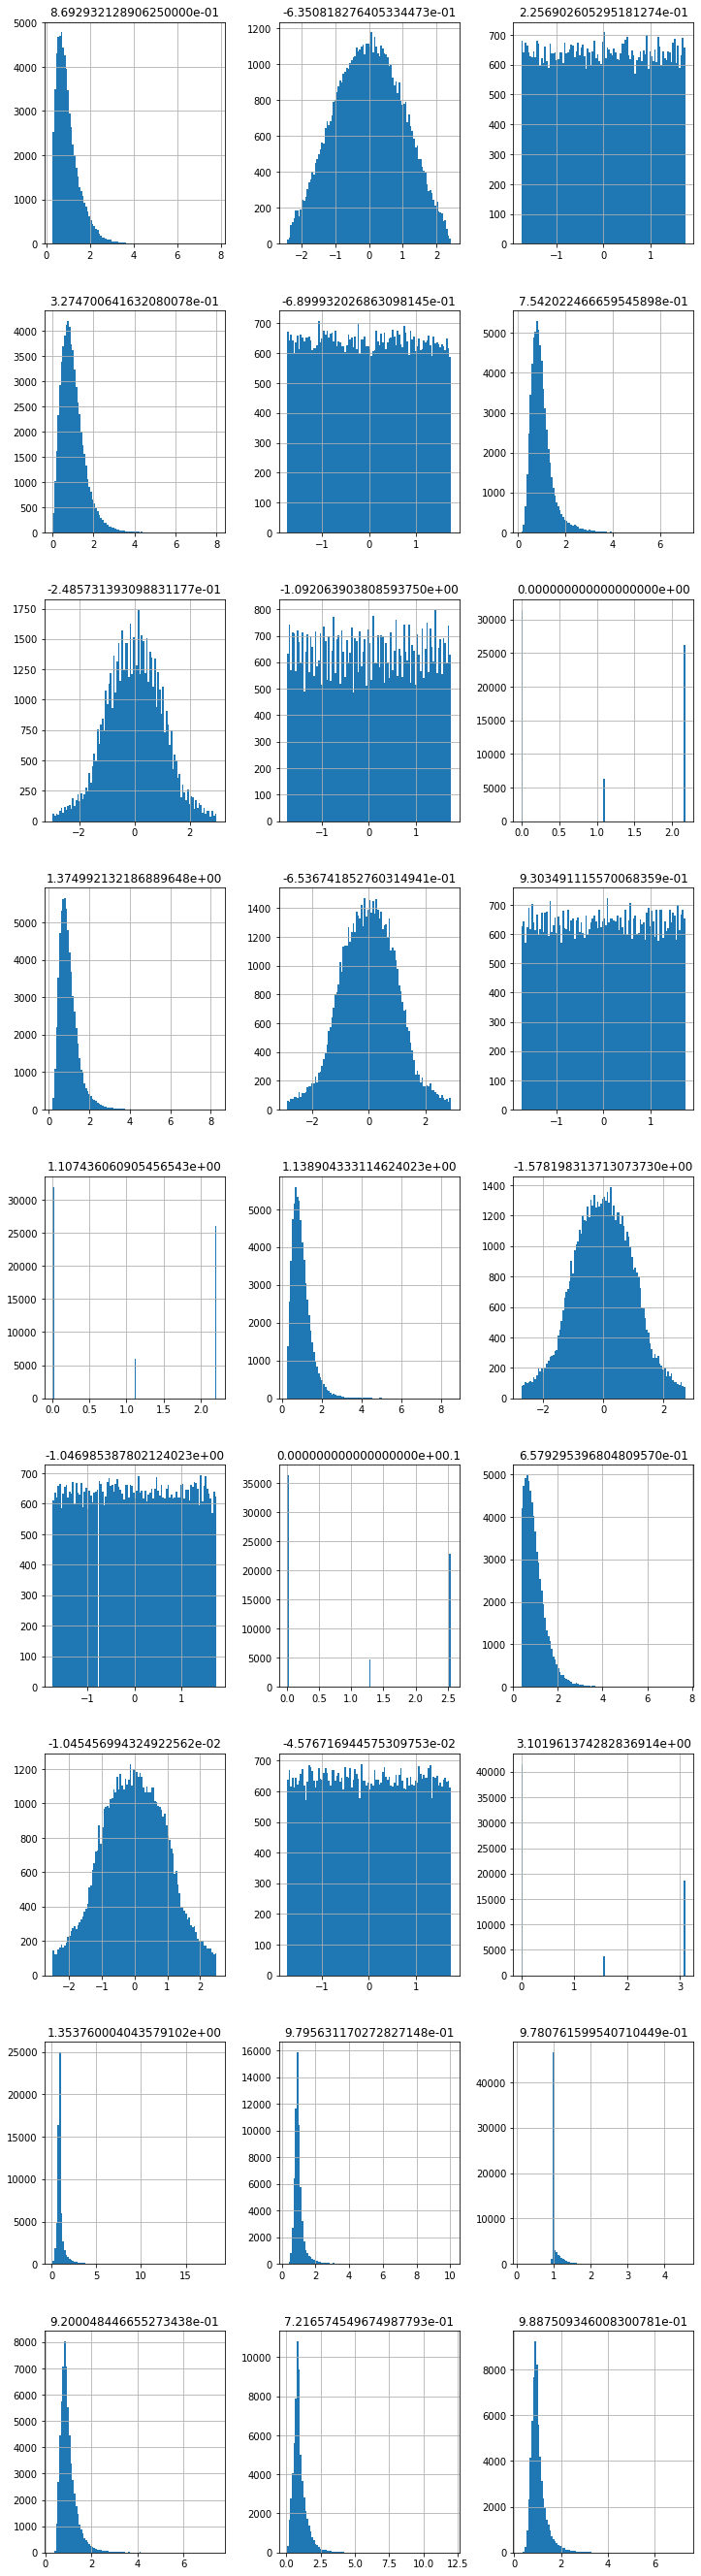

In [ ]:
from itertools import combinations
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(X_train.columns)//3, 3, figsize=(12, 48))

i = 0
for triaxis in axes:
    for axis in triaxis:
        X_train.hist(column = X_train.columns[i], bins = 100, ax=axis)
        i = i+1

### We begin by training several classifiers; Logistic Regression, SGD Classifier, Random Forest, Adaboost, and XGBoost. Then we try neural networks. For all the models, we will be comparing the confusion matrix and the ROC curve to determine the best performing model for the above mentioned task.

# Boosted Decision Tree model

**Setup the Boosted Decision Tree model** (BDT explanation [here](https://docs.microsoft.com/en-us/azure/machine-learning/algorithm-module-reference/boosted-decision-tree-regression#:~:text=Boosting%20means%20that%20each%20tree,small%20risk%20of%20less%20coverage.))

In [ ]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200, learning_rate=0.5)

In [ ]:
estimators = [10, 50, 100, 200, 500] 
lr_rate = [0.01, 0.05, 0.1, 0.5]
grid_values = {'n_estimators': estimators, 'learning_rate':lr_rate}
clf = GridSearchCV(ada_clf,
                   grid_values, scoring='roc_auc', n_jobs=-1, cv=3)
clf.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                          learning_rate=0.5, n_estimators=200),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5],
                         'n_estimators': [10, 50, 100, 200, 500]},
             scoring='roc_auc')

In [ ]:
clf.best_estimator_

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=500)

#### Finer search

In [ ]:
estimators = [300, 400, 500,600] 
lr_rate = [0.4, 0.5,0.6]
grid_values = {'n_estimators': estimators, 'learning_rate':lr_rate}
clf = GridSearchCV(ada_clf,
                   grid_values, scoring='roc_auc', n_jobs=-1, cv=3)
clf.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                          learning_rate=0.5, n_estimators=200),
             n_jobs=-1,
             param_grid={'learning_rate': [0.4, 0.5, 0.6],
                         'n_estimators': [300, 400, 500, 600]},
             scoring='roc_auc')

In [ ]:
best_adaboost = clf.best_estimator_

**Train the best Boosted Decision Tree model**

In [ ]:
best_adaboost.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.4, n_estimators=600)

**Predict on new testing data**

In [ ]:
predictions = best_adaboost.predict(X_test)

**Print confusion matrix**

In [ ]:
confusion_matrix(y_test, predictions)

array([[24745, 12794],
       [11390, 31071]], dtype=int64)

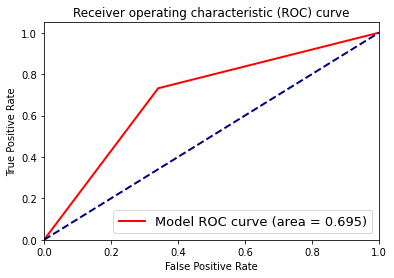

In [ ]:
fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw, label='Model ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right", fontsize=13)
plt.show()

# Logistic Regression Classifier:

**Hyperparameter tuning**

In [ ]:

grid_lr = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}

logreg = LogisticRegression(solver="liblinear")

logreg_cv = GridSearchCV(logreg,grid_lr,cv=4,verbose=3)

logreg_cv.fit(X_train,y_train)

Fitting 4 folds for each of 14 candidates, totalling 56 fits
[CV] C=0.001, penalty=l1 .............................................
[CV] ................. C=0.001, penalty=l1, score=0.612, total=   0.2s
[CV] C=0.001, penalty=l1 .............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ................. C=0.001, penalty=l1, score=0.602, total=   0.2s
[CV] C=0.001, penalty=l1 .............................................
[CV] ................. C=0.001, penalty=l1, score=0.613, total=   0.2s
[CV] C=0.001, penalty=l1 .............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] ................. C=0.001, penalty=l1, score=0.605, total=   0.2s
[CV] C=0.001, penalty=l2 .............................................
[CV] ................. C=0.001, penalty=l2, score=0.636, total=   0.3s
[CV] C=0.001, penalty=l2 .............................................
[CV] ................. C=0.001, penalty=l2, score=0.630, total=   0.3s
[CV] C=0.001, penalty=l2 .............................................
[CV] ................. C=0.001, penalty=l2, score=0.634, total=   0.4s
[CV] C=0.001, penalty=l2 .............................................
[CV] ................. C=0.001, penalty=l2, score=0.625, total=   0.3s
[CV] C=0.01, penalty=l1 ..............................................
[CV] .................. C=0.01, penalty=l1, score=0.646, total=   0.5s
[CV] C=0.01, penalty=l1 ..............................................
[CV] .................. C=0.01, penalty=l1, score=0.640, total=   0.5s
[CV] C=0.01, penalty=l1 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  56 out of  56 | elapsed:   31.0s finished


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

**Best Parameters**

In [ ]:
print("Best parameters of Logistic Regression from grid search:")
print(logreg_cv.best_params_)

Best parameters of Logistic Regression from grid search:
{'C': 1.0, 'penalty': 'l2'}


In [ ]:
logreg_best_est = logreg_cv.best_estimator_
logreg_best_est

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

**Fitting the logistic model with best parameters**

In [ ]:
best_logistic = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

best_logistic.fit(X_train, y_train)

C:\Users\shambhu\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(n_jobs=-1, solver='liblinear')

In [ ]:
predictions = best_logistic.predict(X_test)

**Confusion Matrix**

In [ ]:
print("Confusion Matrix for Logistic Regression Classifier:")
confusion_matrix(y_test,predictions)

Confusion Matrix for Logistic Regression Classifier:


array([[19754, 17785],
       [11020, 31441]], dtype=int64)

**ROC Curve and Score**

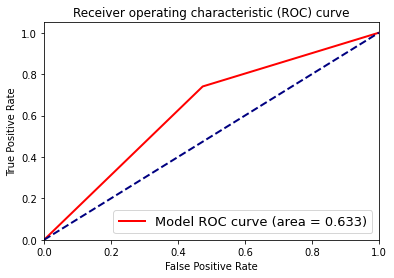

In [ ]:
fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw, label='Model ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right", fontsize=13)
plt.show()

In [ ]:
z = confusion_matrix(y_test,predictions)

err_lr = (z[1][0]+z[0][1])/(z[0][0]+z[0][1]+z[1][0]+z[1][1])
acc_lr = 1-err_lr
print("Error of logistic regression classifier on test set:",err_lr)
print("Accuracy of logistic regression classifier on test set:",acc_lr)

Error of logistic regression classifier on test set: 0.3600625
Accuracy of logistic regression classifier on test set: 0.6399375


# SGD Classfier

In [ ]:
sgd_clf = SGDClassifier(alpha=0.01, early_stopping=True, loss='modified_huber',
              max_iter=10000, n_jobs=-1, warm_start=True)
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.01, early_stopping=True, loss='modified_huber',
              max_iter=10000, n_jobs=-1, warm_start=True)

In [ ]:
sgd_predictions = sgd_clf.predict(X_test)

#### Confusion Matrix

In [ ]:
confusion_matrix(y_test, sgd_predictions)

array([[18653, 18886],
       [10517, 31944]], dtype=int64)

#### ROC Curve

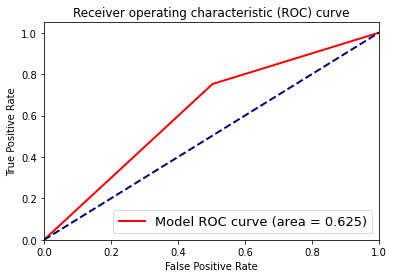

In [ ]:
fpr, tpr, _ = roc_curve(y_test, sgd_predictions)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw, label='Model ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right", fontsize=13)
plt.show()

# Random Forest Classifier

**Hyperparameter Tuning**

In [ ]:
estimator = RandomForestClassifier()

estimators = [10, 50, 100, 200, 500] 
max_depths = [3, 6, 10, 15, 20] 
grid_values = {'n_estimators': estimators, 'max_depth':max_depths}
clf = GridSearchCV(RandomForestClassifier(),
                   grid_values, scoring='roc_auc', n_jobs=-1, cv=3)
clf.fit(X_train, y_train)
best_n_estimators_value = clf.best_params_['n_estimators']
best_max_depth_value = clf.best_params_['max_depth']
best_score = clf.best_score_

**Best Parameters from Grid Search**

In [ ]:
print("Best parameters of RF from grid search:")
print(clf.best_params_)

clf_best_est = clf.best_estimator_
print("Best estimator:",clf_best_est)

Best parameters of RF from grid search:
{'max_depth': 20, 'n_estimators': 500}
Best estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


**Fitting RandomClassifer using optimized hyperparameters**

In [ ]:
best_RF = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

best_RF.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, n_estimators=500)

In [ ]:
RF_predictions = best_RF.predict(X_test)

**Confusion Matrix**

In [ ]:
print("Confusion Matrix for Random Forest Classifier:")
confusion_matrix(y_test,RF_predictions)

Confusion Matrix for Random Forest Classifier:


array([[26397, 11142],
       [10327, 32134]], dtype=int64)

**ROC Curve and Score**

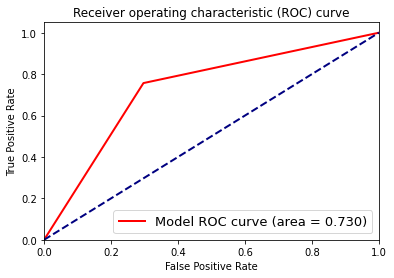

In [ ]:
fpr, tpr, _ = roc_curve(y_test, RF_predictions)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw, label='Model ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right", fontsize=13)
plt.show()

In [ ]:
z2 = confusion_matrix(y_test,RF_predictions)

err_rf = (z2[1][0]+z2[0][1])/(z2[0][0]+z2[0][1]+z2[1][0]+z2[1][1])
acc_rf = 1-err_rf
print("Error of logistic regression classifier on test set:",err_rf)
print("Accuracy of logistic regression classifier on test set:",acc_rf)

Error of logistic regression classifier on test set: 0.2683625
Accuracy of logistic regression classifier on test set: 0.7316374999999999


# XGB Classifier

In [ ]:
xgb_clf = XGBClassifier(objective='binary:logistic', 
                        random_state=42, 
                        n_jobs=-1,
                        eval_metric=["error", "auc"], 
                        booster='dart', 
                        sample_type= 'weighted',
                        normalize_type= 'forest',
                        sampling_method='uniform',
                        use_label_encoder=False) #tree_method = "gpu_hist" may create data loss 
      
param_search = {
    "n_estimators" : rnd.randint(0,1000,50),
    "max_depth" : rnd.randint(0,20,10),
    "learning_rate" : rnd.uniform(0,0.5,10),
    #'gamma' : rnd.uniform(0,10),
    "colsample_bytree" : rnd.uniform(0,1.,10),
    "colsample_bylevel" : rnd.uniform(0,1.,10),
    "colsample_bynode" : rnd.uniform(0,1.,10),
    #"subsample" : rnd.uniform(0.2,1.,10),
    #"rate_drop" : rnd.uniform(0,1.,10),
    #"skip_drop" : rnd.uniform(0,1.,10)
}
scoring = {
    'AUC': 'roc_auc', 
    'Accuracy': make_scorer(accuracy_score)
}
num_folds = 3
num_iter = 50
kfold = StratifiedKFold(n_splits=num_folds, random_state=42, shuffle=True)
grid_search = RandomizedSearchCV(
    estimator=xgb_clf, 
    param_distributions=param_search,
    cv=kfold,
    scoring=scoring,
    #n_jobs=-1,
    n_iter=num_iter,
    refit="AUC",
)
#eval_set=[(X_val,y_val)]
best_model = grid_search.fit(X_train,y_train)

#### Best estimator

In [ ]:
best_model.best_estimator_

XGBClassifier(base_score=0.5, booster='dart',
              colsample_bylevel=0.4339378851311694,
              colsample_bynode=0.6620406126065055,
              colsample_bytree=0.8211342369222487, eval_metric=['error', 'auc'],
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.05075727570581978,
              max_delta_step=0, max_depth=16, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=638, n_jobs=-1,
              normalize_type='forest', num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, sample_type='weighted',
              sampling_method='uniform', scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

In [11]:
xgd_best = XGBClassifier(base_score=0.5, booster='dart',
              colsample_bylevel=0.4339378851311694,
              colsample_bynode=0.6620406126065055,
              colsample_bytree=0.8211342369222487, eval_metric=['error', 'auc'],
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.05075727570581978,
              max_delta_step=0, max_depth=16, min_child_weight=1,
              n_estimators=638, n_jobs=-1,
              normalize_type='forest', num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, sample_type='weighted',
              sampling_method='uniform', scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1)
xgd_best.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='dart',
              colsample_bylevel=0.4339378851311694,
              colsample_bynode=0.6620406126065055,
              colsample_bytree=0.8211342369222487, eval_metric=['error', 'auc'],
              gamma=0, gpu_id=0, interaction_constraints='',
              learning_rate=0.05075727570581978, max_delta_step=0, max_depth=16,
              min_child_weight=1, missing=None, n_estimators=638, n_jobs=-1,
              normalize_type='forest', nthread=None, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, sample_type='weighted', sampling_method='uniform',
              scale_pos_weight=1, seed=None, silent=None, subsample=1,
              tree_method='exact', ...)

In [12]:
predictions = xgd_best.predict(X_test)

In [13]:
print("Confusion Matrix for XGBoost Classifier:")
confusion_matrix(y_test,predictions)

Confusion Matrix for XGBoost Classifier:


array([[26984, 10555],
       [ 9945, 32516]])

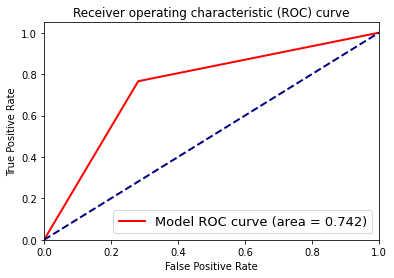

In [14]:
fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw, label='Model ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right", fontsize=13)
plt.show()

**Now we want to build a voting classifier including the five classifiers that we fitted above. So far, XGBClassifier performs the best, and we expect a performance enhancement from voting classifier. Let's try it out.**

In [ ]:
# calling the individual classifiers

import numpy.random as rnd
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report

adaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.4, n_estimators=600)

logistic = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

sgd = SGDClassifier(alpha=0.01, early_stopping=True, loss='modified_huber',
              max_iter=10000, n_jobs=-1, warm_start=True)

rand_forest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

xgboost = XGBClassifier(base_score=0.5, booster='dart',
              colsample_bylevel=0.4339378851311694,
              colsample_bynode=0.6620406126065055,
              colsample_bytree=0.8211342369222487, eval_metric=['error', 'auc'],
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.05075727570581978,
              max_delta_step=0, max_depth=16, min_child_weight=1,
              monotone_constraints='()', n_estimators=638, n_jobs=-1,
              normalize_type='forest', num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, sample_type='weighted',
              sampling_method='uniform', scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1)

In [ ]:
# creating a voting classifier
voting_clf = VotingClassifier(estimators= [('lg', logistic), ('sg', sgd), ('ad', adaboost), ('rf', rand_forest), ('xg', xgboost)], voting= 'hard')
voting_clf.fit(X_train, y_train)

C:\Users\shambhu\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[14:54:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




VotingClassifier(estimators=[('lg',
                              LogisticRegression(n_jobs=-1,
                                                 solver='liblinear')),
                             ('sg',
                              SGDClassifier(alpha=0.01, early_stopping=True,
                                            loss='modified_huber',
                                            max_iter=10000, n_jobs=-1,
                                            warm_start=True)),
                             ('ad',
                              AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                                 learning_rate=0.4,
                                                 n_estimators=600)),
                             ('rf',
                              RandomForestClassifier(max_dep...
                                            max_delta_step=0, max_depth=16,
                                            min_child_weight=1, missi

In [ ]:
voting_predictions= voting_clf.predict(X_test)

**Confusion matrix**

In [ ]:
print("The confusion matrix for voting classifier.")
confusion_matrix(y_test, voting_predictions)

The confusion matrix for voting classifier.


array([[24317, 13222],
       [ 9448, 33013]], dtype=int64)

In [ ]:
print("The acccuracy score is", accuracy_score(y_test, voting_predictions))

The acccuracy score is 0.716625


**ROC Curve**

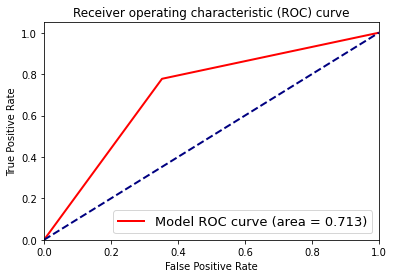

In [ ]:
fpr, tpr, _ = roc_curve(y_test, voting_predictions)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw, label='Model ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right", fontsize=13)
plt.show()

# Neural Networks

In [ ]:
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense

In [14]:
model = Sequential([Dense(28, input_dim=28, activation='relu'),
                  Dense(15, activation='relu'),
                  Dense(10, activation='relu'),
                  Dense(5, activation='relu'),
                  Dense(1, activation='sigmoid'),
                  ])

In [15]:
# compile the model and train it
batch_size=32
s = 30*len(X_train)//batch_size
learning_schedule = tensorflow.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.1, decay_steps=s ,decay_rate=0.1)

model.compile(loss='binary_crossentropy', optimizer = tensorflow.keras.optimizers.Adam(), metrics=['accuracy'])


history=model.fit(X_train, y_train,validation_data=(X_val,y_val),epochs=30, batch_size=32, verbose=1)


Epoch 1/30
220000/220000 [==============================] - 569s 3ms/step - loss: 0.5791 - accuracy: 0.6897 - val_loss: 0.5430 - val_accuracy: 0.7210
Epoch 2/30
220000/220000 [==============================] - 545s 2ms/step - loss: 0.5372 - accuracy: 0.7255 - val_loss: 0.5264 - val_accuracy: 0.7329
Epoch 3/30
220000/220000 [==============================] - 546s 2ms/step - loss: 0.5256 - accuracy: 0.7335 - val_loss: 0.5277 - val_accuracy: 0.7318
Epoch 4/30
220000/220000 [==============================] - 541s 2ms/step - loss: 0.5211 - accuracy: 0.7365 - val_loss: 0.5206 - val_accuracy: 0.7359
Epoch 5/30
220000/220000 [==============================] - 532s 2ms/step - loss: 0.5182 - accuracy: 0.7383 - val_loss: 0.5216 - val_accuracy: 0.7361
Epoch 6/30
220000/220000 [==============================] - 545s 2ms/step - loss: 0.5167 - accuracy: 0.7393 - val_loss: 0.5144 - val_accuracy: 0.7403
Epoch 7/30
220000/220000 [==============================] - 555s 3ms/step - loss: 0.5156 - accuracy:

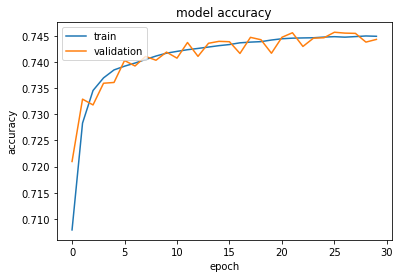

In [16]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [17]:
# evaluate the keras model
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

55000/55000 [==============================] - 70s 1ms/step - loss: 0.5081 - accuracy: 0.7446
Accuracy: 74.46


**Confusion matrix**

In [18]:
print("The confusion matrix for Neural network.")
nn_predictions = model.predict_classes(X_test)
confusion_matrix(y_test, nn_predictions)


The confusion matrix for Neural network.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[581960, 246510],
       [202949, 728581]])

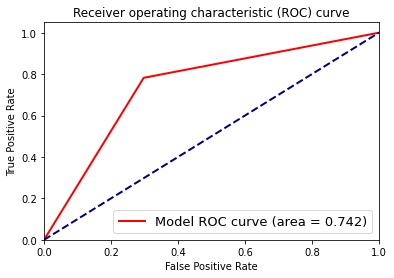

In [19]:
fpr, tpr, _ = roc_curve(y_test, nn_predictions)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw, label='Model ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right", fontsize=13)
plt.show()

One can clearly observe that neural networks outperforms other classifiers.

**References:**

Baldi, P., Sadowski P., and Whiteson D. “Searching for Exotic Particles in High-energy Physics with Deep Learning.” Nature Communications 5 (July 2, 2014).